# Random Forest
Author: Javier Pelegrin Garcia

Date: 15/05/2023

This notebook is an approach to the analysis of peptide data detected with mass spectrometry.

The purpose of these models is to detect the percentage of peptides charged to 2+ or 3+

To run this notebook it is necessary to run <a href="./main.ipynb">Main</a> first.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pyteomics import mass
from pyteomics import electrochem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error

from utils.parseData import mz_to_mass
from utils.parseData import count_basic_residues
from utils.parseData import gererate_dic
from utils.parseData import adjacent_values
from utils.parseData import set_axis_style
from utils.parseData import PROTON_MASS
from utils.parseData import PH


import joblib

IS_TRAINED_2 = True
IS_TRAINED_3 = True
IS_TRAINED_  = True
IS_TRAINED   = True

# laad de data
dic = joblib.load('data/dic.pkl')

#load the model
try:
    modele_rf_2 = joblib.load('models/model_rf_2.rdf')
    modele_rf_3 = joblib.load('models/model_rf_3.rdf')
    modele_rf   = joblib.load('models/model_rf.rdf')
    modele_rf_  = joblib.load('models/model_rf_.rdf')
except:
    pass

## Model For charge 2

### Create DataSet for charge 2:
This data only take the data where observated charge = 2 and where persent < 100%

In [2]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass_2 = []
    residues_2 = []
    charge_2 = []
    mass_2_excel = []
    labels_2 = []

    mass_3 = []
    residues_3 = []
    charge_3 = []
    mass_3_excel = []
    labels_3 = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j == 2 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                mass_2.append(dic[i][j]['Masse'])
                mass_2_excel.append(dic[i][j]['Mass_excel'])
                residues_2.append(count_basic_residues(dic[i][j]['sequence']))
                charge_2.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                labels_2.append(dic[i][j]['%'])
            if j == 3 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues:
                mass_3.append(dic[i][j]['Masse'])
                mass_3_excel.append(dic[i][j]['Mass_excel'])
                residues_3.append(count_basic_residues(dic[i][j]['sequence']))
                charge_3.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                labels_3.append(dic[i][j]['%'])
    
    return mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3

mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3 = generate_data(dic, min_charge=2)

def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c] for m, r, c in zip(mass_2_excel, residues_2, charge_2) ])
y_train = np.array(labels_2)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test*100).round().astype(int)
y_train = (y_train*100).round().astype(int)

y_test_2 = y_test.copy()
x_test_2 = x_test.copy()

# Affichage du nombre d'exemples totales dans le corpus
print('Total corpus size')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTraining data size')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTest data size')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

(1886, 3) (1886,)
Total corpus size
	• train : 1414 exemples
	• test : 472 exemples

Training data size
	• X_train (masse,residues,charge): (1414, 3)
	• y_train (labels) : (1414,)

Test data size
	• X_test (masse,residues,charge) : (472, 3)
	• y_test (labels) : (472,)


### Training Model

In [3]:
if not IS_TRAINED_2:
    modele_rf_2 = RandomForestClassifier(n_estimators=10000, max_depth=10 ,random_state=123, min_samples_split=20, criterion='gini', min_samples_leaf=5, bootstrap=True, n_jobs=6, warm_start=True)
    modele_rf_2.fit(x_train, y_train)
    joblib.dump(modele_rf_2, 'models/model_rf_2.rdf')

In [4]:
y_pred_2 = modele_rf_2.predict(x_test)

### Testing Model

RMSE: 18.891415860658487


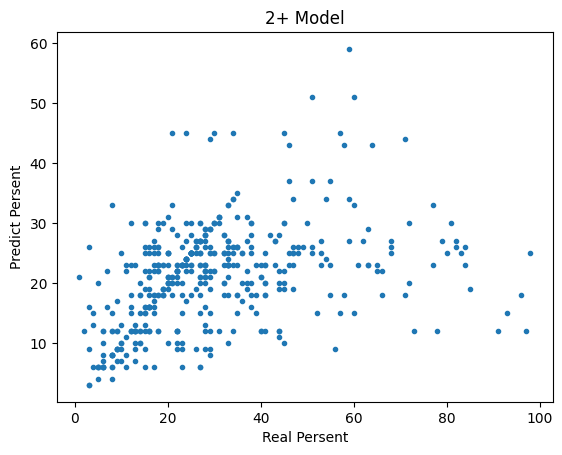

In [5]:
print(f'RMSE: {mean_squared_error(y_test_2, y_pred_2, squared=False)}')
plt.plot(y_test_2, y_pred_2,'.')
plt.xlabel('Real Persent')
plt.ylabel('Predict Persent')
plt.title('2+ Model')
plt.show()

In [6]:
real_pers=dic[7709][2]['%']
mass = dic[7709][2]['Mass_excel']
res = count_basic_residues(dic[7709][2]['sequence'])
charge_pred = electrochem.charge(dic[7709][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_2.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8286][2]['%']
mass = dic[8286][2]['Mass_excel']
res = count_basic_residues(dic[8286][2]['sequence'])
charge_pred = electrochem.charge(dic[8286][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_2.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8621][2]['%']
mass = dic[8621][2]['Mass_excel']
res = count_basic_residues(dic[8621][2]['sequence'])
charge_pred = electrochem.charge(dic[8621][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_2.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8714][2]['%']
mass = dic[8714][2]['Mass_excel']
res = count_basic_residues(dic[8714][2]['sequence'])
charge_pred = electrochem.charge(dic[8714][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_2.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[2273084][2]['%']
mass = dic[2273084][2]['Mass_excel']
res = count_basic_residues(dic[2273084][2]['sequence'])
charge_pred = electrochem.charge(dic[2273084][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_2.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[20078][2]['%']
mass = dic[20078][2]['Mass_excel']
res = count_basic_residues(dic[20078][2]['sequence'])
charge_pred = electrochem.charge(dic[20078][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_2.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

Predict Persent: 21%, Real Persent: 17.016453983493005%
	Masse : 1886.9650622578124
	Residues : 2
	Charge : 1.9955843362958696
Predict Persent: 13%, Real Persent: 20.954622215496123%
	Masse : 1945.88535034375
	Residues : 2
	Charge : 1.7061827109108385
Predict Persent: 27%, Real Persent: 94.08691914172927%
	Masse : 1789.885106203125
	Residues : 1
	Charge : 0.8901029068908255
Predict Persent: 10%, Real Persent: 11.479726298092894%
	Masse : 1514.7431384296874
	Residues : 3
	Charge : 3.1242662858948718
Predict Persent: 10%, Real Persent: 9.87336812959993%
	Masse : 1240.6564685078124
	Residues : 3
	Charge : 2.9413451760276823
Predict Persent: 29%, Real Persent: 99.0732717260013%
	Masse : 1486.69492065625
	Residues : 1
	Charge : 0.9433431220928481


In [7]:
res_1 = []
persent_1 = []
res_2 = []
persent_2 = []
res_3 = []
persent_3 = []
littel_persent = []
littel_persent_real = []
mean_persent = []
mean_persent_real = []
big_persent = []
big_persent_real = []
for i in dic.keys():
    for j in dic[i].keys():
        if j == 2:
            if count_basic_residues(dic[i][j]['sequence']) == 1 and dic[i][j]['%'] < 1: #and dic[i][j]['%'] > 0.9 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > 2:
                res_1.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                persent_1.append(dic[i][j]['%'])
            if count_basic_residues(dic[i][j]['sequence']) == 2 and dic[i][j]['%'] < 1:
                res_2.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                persent_2.append(dic[i][j]['%'])
            if count_basic_residues(dic[i][j]['sequence']) == 3 and dic[i][j]['%'] < 1:
                res_3.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                persent_3.append(dic[i][j]['%'])
            if dic[i][j]['%'] < 0.4:
                littel_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                littel_persent_real.append(dic[i][j]['%'])
            elif dic[i][j]['%'] > 0.4 and dic[i][j]['%'] < 0.6:
                mean_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                mean_persent_real.append(dic[i][j]['%'])
            elif dic[i][j]['%'] > 0.6 and dic[i][j]['%'] < 1:
                big_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                big_persent_real.append(dic[i][j]['%'])

pred_1 = modele_rf_2.predict(res_1)
pred_2 = modele_rf_2.predict(res_2)
pred_3 = modele_rf_2.predict(res_3)
pred_littel = modele_rf_2.predict(littel_persent)
pred_mean = modele_rf_2.predict(mean_persent)
pred_big = modele_rf_2.predict(big_persent)

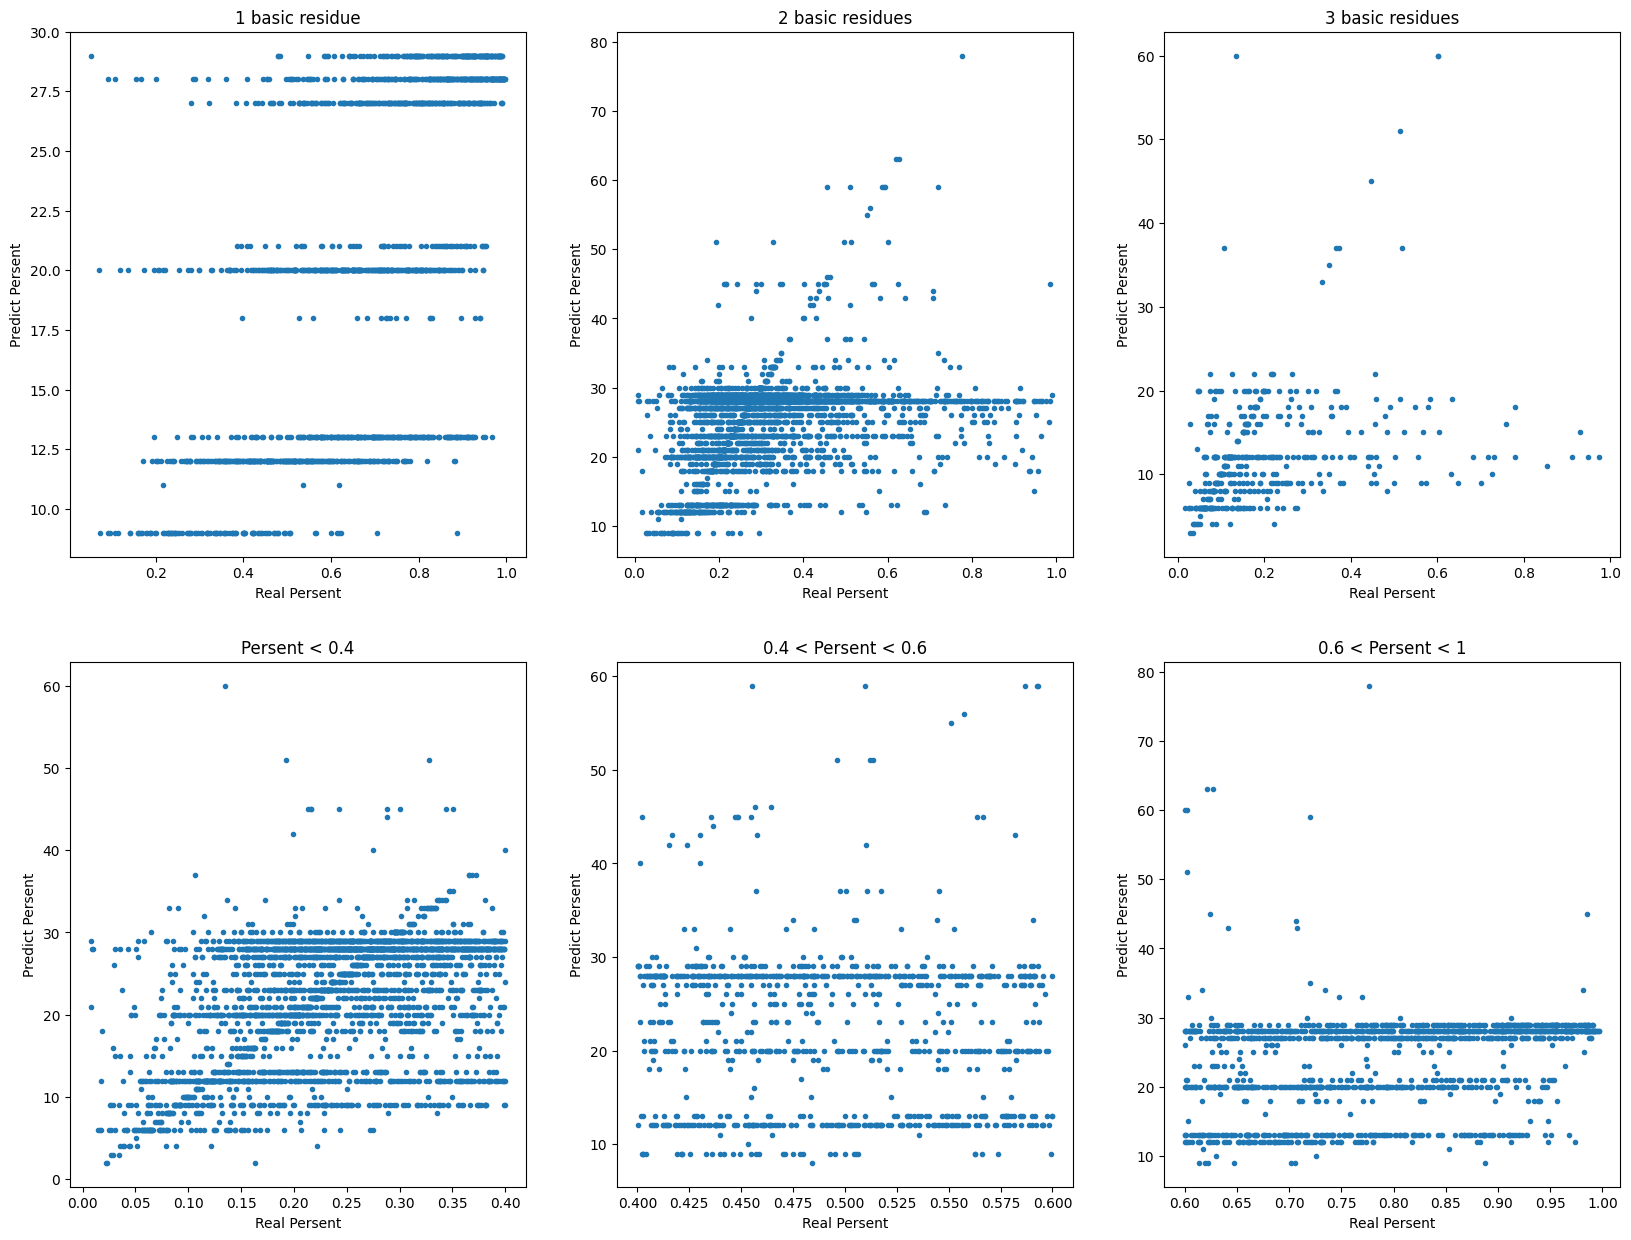

In [8]:
fig, ax = plt.subplots(2,3, figsize=(20,15))
ax[0][0].plot(persent_1, pred_1,'.')
ax[0][0].set_title('1 basic residue')
ax[0][0].set_xlabel('Real Persent')
ax[0][0].set_ylabel('Predict Persent')
ax[0][1].plot(persent_2, pred_2,'.')
ax[0][1].set_title('2 basic residues')
ax[0][1].set_xlabel('Real Persent')
ax[0][1].set_ylabel('Predict Persent')
ax[0][2].plot(persent_3, pred_3,'.')
ax[0][2].set_title('3 basic residues')
ax[0][2].set_xlabel('Real Persent')
ax[0][2].set_ylabel('Predict Persent')
ax[1][0].plot(littel_persent_real, pred_littel,'.')
ax[1][0].set_title('Persent < 0.4')
ax[1][0].set_xlabel('Real Persent')
ax[1][0].set_ylabel('Predict Persent')
ax[1][1].plot(mean_persent_real, pred_mean,'.')
ax[1][1].set_title('0.4 < Persent < 0.6')
ax[1][1].set_xlabel('Real Persent')
ax[1][1].set_ylabel('Predict Persent')
ax[1][2].plot(big_persent_real, pred_big,'.')
ax[1][2].set_title('0.6 < Persent < 1')
ax[1][2].set_xlabel('Real Persent')
ax[1][2].set_ylabel('Predict Persent')
plt.show()

___
## Model for charge 3
### Create DataSet for charge 3:
This data only take the data where observated charge = 3 and where persent < 100%

In [9]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass_2 = []
    residues_2 = []
    charge_2 = []
    mass_2_excel = []
    labels_2 = []

    mass_3 = []
    residues_3 = []
    charge_3 = []
    mass_3_excel = []
    labels_3 = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j == 2 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                mass_2.append(dic[i][j]['Masse'])
                mass_2_excel.append(dic[i][j]['Mass_excel'])
                residues_2.append(count_basic_residues(dic[i][j]['sequence']))
                charge_2.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                labels_2.append(dic[i][j]['%'])
            if j == 3 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues:
                mass_3.append(dic[i][j]['Masse'])
                mass_3_excel.append(dic[i][j]['Mass_excel'])
                residues_3.append(count_basic_residues(dic[i][j]['sequence']))
                charge_3.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                labels_3.append(dic[i][j]['%'])
    
    return mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3

mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3 = generate_data(dic, min_charge=2)

def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c] for m, r, c in zip(mass_3_excel, residues_3, charge_3) ])
y_train = np.array(labels_3)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

try:
    del mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3
except:
    pass

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test*100).round().astype(int)
y_train = (y_train*100).round().astype(int)

y_test_3 = y_test.copy()
x_test_3 = x_test.copy()


# Affichage du nombre d'exemples totales dans le corpus
print('Total corpus size')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTrain data size')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTest data size')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

(2280, 3) (2280,)
Total corpus size
	• train : 1710 exemples
	• test : 570 exemples

Train data size
	• X_train (masse,residues,charge): (1710, 3)
	• y_train (labels) : (1710,)

Test data size
	• X_test (masse,residues,charge) : (570, 3)
	• y_test (labels) : (570,)


## Training Model

In [10]:
if not IS_TRAINED_3:
    modele_rf_3 = RandomForestClassifier(n_estimators=10000, max_depth=10 ,random_state=123, min_samples_split=20, criterion='gini', min_samples_leaf=5, bootstrap=True, n_jobs=6, warm_start=True)
    modele_rf_3.fit(x_train, y_train)
    joblib.dump(modele_rf_3, 'models/model_rf_3.rdf')

In [11]:
y_pred_3 = modele_rf_3.predict(x_test)

## Testing Model

RMSE: 19.24163067094868


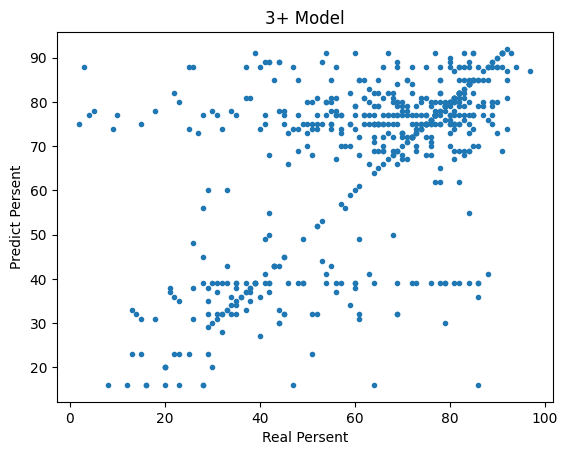

In [12]:
print(f'RMSE: {mean_squared_error(y_test_3,y_pred_3, squared=False)}')
plt.plot(y_test_3, y_pred_3,'.')
plt.xlabel('Real Persent')
plt.ylabel('Predict Persent')
plt.title('3+ Model')
plt.show()

In [13]:
real_pers=dic[7709][3]['%']
mass = dic[7709][3]['Mass_excel']
res = count_basic_residues(dic[7709][3]['sequence'])
charge_pred = electrochem.charge(dic[7709][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8286][3]['%']
mass = dic[8286][3]['Mass_excel']
res = count_basic_residues(dic[8286][3]['sequence'])
charge_pred = electrochem.charge(dic[8286][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8621][3]['%']
mass = dic[8621][3]['Mass_excel']
res = count_basic_residues(dic[8621][3]['sequence'])
charge_pred = electrochem.charge(dic[8621][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8714][3]['%']
mass = dic[8714][3]['Mass_excel']
res = count_basic_residues(dic[8714][3]['sequence'])
charge_pred = electrochem.charge(dic[8714][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[2273084][3]['%']
mass = dic[2273084][3]['Mass_excel']
res = count_basic_residues(dic[2273084][3]['sequence'])
charge_pred = electrochem.charge(dic[2273084][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

# real_pers=dic[20078][3]['%']
# mass = dic[20078][3]['Mass_excel']
# res = count_basic_residues(dic[20078][3]['sequence'])
# charge_pred = electrochem.charge(dic[20078][3]['sequence'], pH=PH)
# print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
# print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

Predict Persent: 79%, Real Persent: 82.98354601650699%
	Masse : 1886.9653546171876
	Residues : 2
	Charge : 1.9955843362958696
Predict Persent: 80%, Real Persent: 79.04537778450388%
	Masse : 1945.8864971953126
	Residues : 2
	Charge : 1.7061827109108385
Predict Persent: 73%, Real Persent: 5.913080858270734%
	Masse : 1789.8852154570313
	Residues : 1
	Charge : 0.8901029068908255
Predict Persent: 89%, Real Persent: 68.62515456251704%
	Masse : 1514.7408673125
	Residues : 3
	Charge : 3.1242662858948718
Predict Persent: 90%, Real Persent: 90.12663187040006%
	Masse : 1240.656150515625
	Residues : 3
	Charge : 2.9413451760276823


In [14]:
res_1 = []
persent_1 = []
res_2 = []
persent_2 = []
res_3 = []
persent_3 = []
littel_persent = []
littel_persent_real = []
mean_persent = []
mean_persent_real = []
big_persent = []
big_persent_real = []
for i in dic.keys():
    for j in dic[i].keys():
        if j == 3:
            if count_basic_residues(dic[i][j]['sequence']) == 1 and dic[i][j]['%'] < 1: #and dic[i][j]['%'] > 0.9 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > 2:
                res_1.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                persent_1.append(dic[i][j]['%'])
            if count_basic_residues(dic[i][j]['sequence']) == 2 and dic[i][j]['%'] < 1:
                res_2.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                persent_2.append(dic[i][j]['%'])
            if count_basic_residues(dic[i][j]['sequence']) == 3 and dic[i][j]['%'] < 1:
                res_3.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                persent_3.append(dic[i][j]['%'])
            if dic[i][j]['%'] < 0.4:
                littel_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                littel_persent_real.append(dic[i][j]['%'])
            elif dic[i][j]['%'] > 0.4 and dic[i][j]['%'] < 0.6:
                mean_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                mean_persent_real.append(dic[i][j]['%'])
            elif dic[i][j]['%'] > 0.6 and dic[i][j]['%'] < 1:
                big_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH)])
                big_persent_real.append(dic[i][j]['%'])

pred_1 = modele_rf_3.predict(res_1)
pred_2 = modele_rf_3.predict(res_2)
pred_3 = modele_rf_3.predict(res_3)
pred_littel = modele_rf_3.predict(littel_persent)
pred_mean = modele_rf_3.predict(mean_persent)
pred_big = modele_rf_3.predict(big_persent)

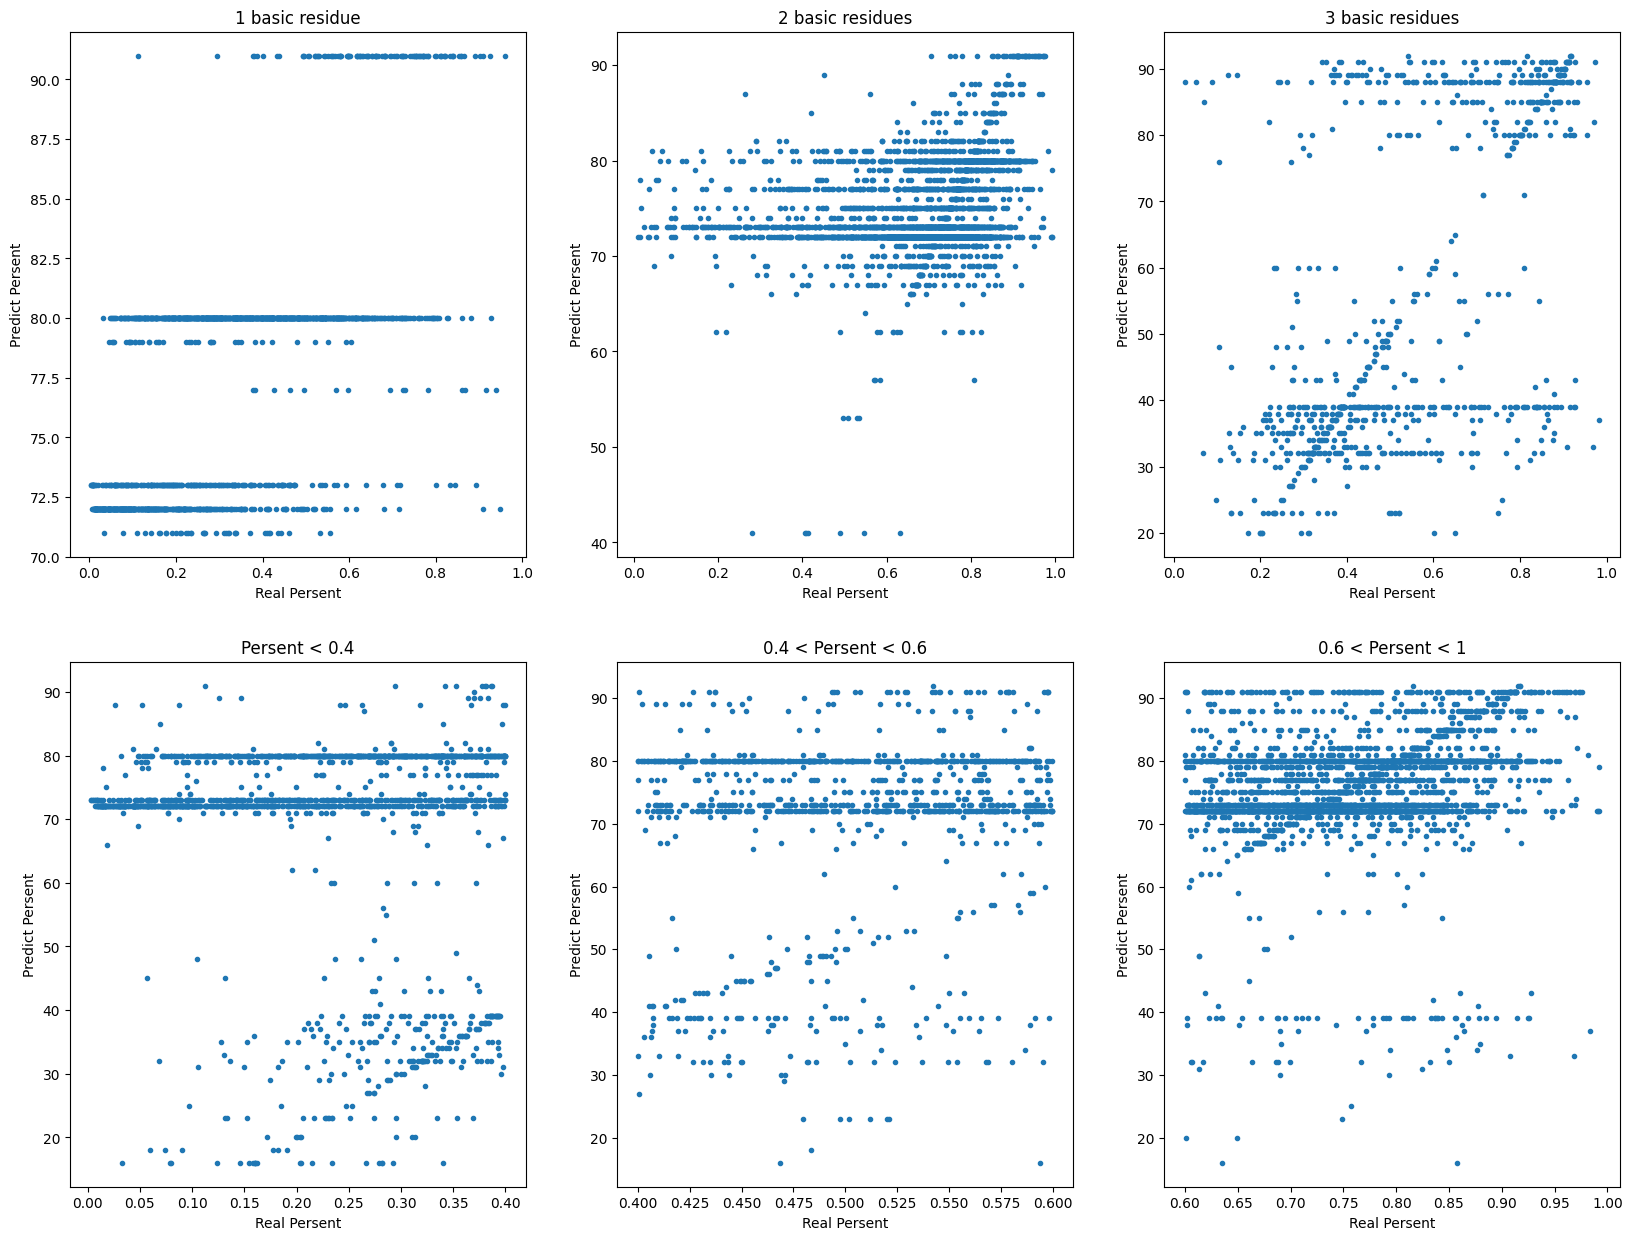

In [15]:
fig, ax = plt.subplots(2,3, figsize=(20,15))
ax[0][0].plot(persent_1, pred_1,'.')
ax[0][0].set_title('1 basic residue')
ax[0][0].set_xlabel('Real Persent')
ax[0][0].set_ylabel('Predict Persent')
ax[0][1].plot(persent_2, pred_2,'.')
ax[0][1].set_title('2 basic residues')
ax[0][1].set_xlabel('Real Persent')
ax[0][1].set_ylabel('Predict Persent')
ax[0][2].plot(persent_3, pred_3,'.')
ax[0][2].set_title('3 basic residues')
ax[0][2].set_xlabel('Real Persent')
ax[0][2].set_ylabel('Predict Persent')
ax[1][0].plot(littel_persent_real, pred_littel,'.')
ax[1][0].set_title('Persent < 0.4')
ax[1][0].set_xlabel('Real Persent')
ax[1][0].set_ylabel('Predict Persent')
ax[1][1].plot(mean_persent_real, pred_mean,'.')
ax[1][1].set_title('0.4 < Persent < 0.6')
ax[1][1].set_xlabel('Real Persent')
ax[1][1].set_ylabel('Predict Persent')
ax[1][2].plot(big_persent_real, pred_big,'.')
ax[1][2].set_title('0.6 < Persent < 1')
ax[1][2].set_xlabel('Real Persent')
ax[1][2].set_ylabel('Predict Persent')
plt.show()

___
## Model general
### Create DataSet for charge 2 and 3:
This data only take the data where observated charge was 2 and 3

In [16]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass_2 = []
    residues_2 = []
    charge_2 = []
    mass_2_excel = []
    real_charge_2 = []
    labels_2 = []

    mass_3 = []
    residues_3 = []
    charge_3 = []
    mass_3_excel = []
    labels_3 = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j == 2 or j == 3:
                if dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                    mass_2.append(dic[i][j]['Masse'])
                    mass_2_excel.append(dic[i][j]['Mass_excel'])
                    residues_2.append(count_basic_residues(dic[i][j]['sequence']))
                    charge_2.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                    real_charge_2.append(j)
                    labels_2.append(dic[i][j]['%'])
            # if j == 3 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues:
            #     mass_3.append(dic[i][j]['Masse'])
            #     mass_3_excel.append(dic[i][j]['Mass_excel'])
            #     residues_3.append(count_basic_residues(dic[i][j]['sequence']))
            #     charge_3.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
            #     labels_3.append(dic[i][j]['%'])
    
    return mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3, real_charge_2

mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3, real_charge_2 = generate_data(dic, min_charge=2)

def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c, rc] for m, r, c, rc in zip(mass_2_excel, residues_2, charge_2, real_charge_2) ])
y_train = np.array(labels_2)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

try:
    del mass_2, residues_2, charge_2, mass_2_excel, labels_2, mass_3, residues_3, charge_3, mass_3_excel, labels_3, real_charge_2
except:
    pass

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test*100).round().astype(int)
y_train = (y_train*100).round().astype(int)

# Affichage du nombre d'exemples totales dans le corpus
print('Total corpus size')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTrain data size')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTest data size')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

(4166, 4) (4166,)
Total corpus size
	• train : 3124 exemples
	• test : 1042 exemples

Train data size
	• X_train (masse,residues,charge): (3124, 4)
	• y_train (labels) : (3124,)

Test data size
	• X_test (masse,residues,charge) : (1042, 4)
	• y_test (labels) : (1042,)


In [17]:
if not IS_TRAINED:
    modele_rf = RandomForestClassifier(n_estimators=10000, max_depth=10 ,random_state=123, min_samples_split=20, criterion='gini', min_samples_leaf=5, bootstrap=True, n_jobs=6, warm_start=True)
    modele_rf.fit(x_train, y_train)
    joblib.dump(modele_rf, 'models/model_rf.rdf')

In [18]:
y_pred = modele_rf.predict(x_test)

RMSE: 18.512873562037644


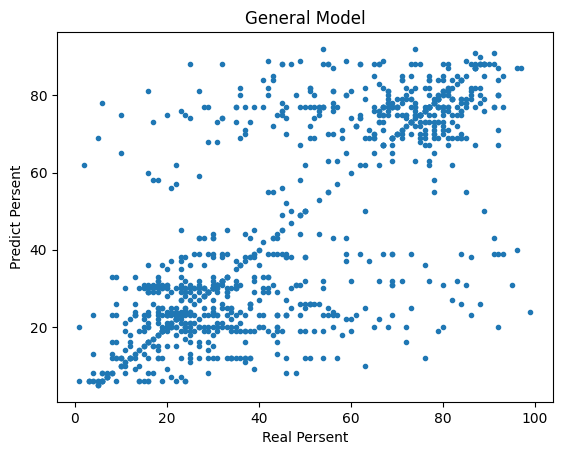

In [19]:
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
plt.plot(y_test, y_pred,'.')
plt.xlabel('Real Persent')
plt.ylabel('Predict Persent')
plt.title('General Model')
plt.show()

In [20]:
res_1 = []
persent_1 = []
res_2 = []
persent_2 = []
res_3 = []
persent_3 = []
littel_persent = []
littel_persent_real = []
mean_persent = []
mean_persent_real = []
big_persent = []
big_persent_real = []
for i in dic.keys():
    for j in dic[i].keys():
        if j == 2 or j == 3:
            if count_basic_residues(dic[i][j]['sequence']) == 1 and dic[i][j]['%'] < 1: #and dic[i][j]['%'] > 0.9 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > 2:
                res_1.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH),j])
                persent_1.append(dic[i][j]['%'])
            if count_basic_residues(dic[i][j]['sequence']) == 2 and dic[i][j]['%'] < 1:
                res_2.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH),j])
                persent_2.append(dic[i][j]['%'])
            if count_basic_residues(dic[i][j]['sequence']) == 3 and dic[i][j]['%'] < 1:
                res_3.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH),j])
                persent_3.append(dic[i][j]['%'])
            if dic[i][j]['%'] < 0.4:
                littel_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH),j])
                littel_persent_real.append(dic[i][j]['%'])
            elif dic[i][j]['%'] > 0.4 and dic[i][j]['%'] < 0.6:
                mean_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH),j])
                mean_persent_real.append(dic[i][j]['%'])
            elif dic[i][j]['%'] > 0.6 and dic[i][j]['%'] < 1:
                big_persent.append([dic[i][j]['Mass_excel'], count_basic_residues(dic[i][j]['sequence']), electrochem.charge(dic[i][j]['sequence'], pH=PH),j])
                big_persent_real.append(dic[i][j]['%'])

pred_1 = modele_rf.predict(res_1)
pred_2 = modele_rf.predict(res_2)
pred_3 = modele_rf.predict(res_3)
pred_littel = modele_rf.predict(littel_persent)
pred_mean = modele_rf.predict(mean_persent)
pred_big = modele_rf.predict(big_persent)

In [21]:
real_pers=dic[7709][2]['%']
mass = dic[7709][2]['Mass_excel']
res = count_basic_residues(dic[7709][2]['sequence'])
charge_pred = electrochem.charge(dic[7709][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')
real_pers=dic[7709][3]['%']
mass = dic[7709][3]['Mass_excel']
res = count_basic_residues(dic[7709][3]['sequence'])
charge_pred = electrochem.charge(dic[7709][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8286][2]['%']
mass = dic[8286][2]['Mass_excel']
res = count_basic_residues(dic[8286][2]['sequence'])
charge_pred = electrochem.charge(dic[8286][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')
real_pers=dic[8286][3]['%']
mass = dic[8286][3]['Mass_excel']
res = count_basic_residues(dic[8286][3]['sequence'])
charge_pred = electrochem.charge(dic[8286][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8621][2]['%']
mass = dic[8621][2]['Mass_excel']
res = count_basic_residues(dic[8621][2]['sequence'])
charge_pred = electrochem.charge(dic[8621][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')
real_pers=dic[8621][3]['%']
mass = dic[8621][3]['Mass_excel']
res = count_basic_residues(dic[8621][3]['sequence'])
charge_pred = electrochem.charge(dic[8621][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[8714][2]['%']
mass = dic[8714][2]['Mass_excel']
res = count_basic_residues(dic[8714][2]['sequence'])
charge_pred = electrochem.charge(dic[8714][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')
real_pers=dic[8714][3]['%']
mass = dic[8714][3]['Mass_excel']
res = count_basic_residues(dic[8714][3]['sequence'])
charge_pred = electrochem.charge(dic[8714][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[2273084][2]['%']
mass = dic[2273084][2]['Mass_excel']
res = count_basic_residues(dic[2273084][2]['sequence'])
charge_pred = electrochem.charge(dic[2273084][2]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')
real_pers=dic[2273084][3]['%']
mass = dic[2273084][3]['Mass_excel']
res = count_basic_residues(dic[2273084][3]['sequence'])
charge_pred = electrochem.charge(dic[2273084][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

real_pers=dic[20078][3]['%']
mass = dic[20078][3]['Mass_excel']
res = count_basic_residues(dic[20078][3]['sequence'])
charge_pred = electrochem.charge(dic[20078][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')
real_pers=dic[20078][3]['%']
mass = dic[20078][3]['Mass_excel']
res = count_basic_residues(dic[20078][3]['sequence'])
charge_pred = electrochem.charge(dic[20078][3]['sequence'], pH=PH)
print(f'Predict Persent: {modele_rf_3.predict(np.array([mass,res,charge_pred]).reshape(1,-1))[0]}%, Real Persent: {real_pers*100}%')
print(f'\tMasse : {mass}\n\tResidues : {res}\n\tCharge : {charge_pred}')

Predict Persent: 79%, Real Persent: 17.016453983493005%
	Masse : 1886.9650622578124
	Residues : 2
	Charge : 1.9955843362958696
Predict Persent: 79%, Real Persent: 82.98354601650699%
	Masse : 1886.9653546171876
	Residues : 2
	Charge : 1.9955843362958696
Predict Persent: 80%, Real Persent: 20.954622215496123%
	Masse : 1945.88535034375
	Residues : 2
	Charge : 1.7061827109108385
Predict Persent: 80%, Real Persent: 79.04537778450388%
	Masse : 1945.8864971953126
	Residues : 2
	Charge : 1.7061827109108385
Predict Persent: 73%, Real Persent: 94.08691914172927%
	Masse : 1789.885106203125
	Residues : 1
	Charge : 0.8901029068908255
Predict Persent: 73%, Real Persent: 5.913080858270734%
	Masse : 1789.8852154570313
	Residues : 1
	Charge : 0.8901029068908255
Predict Persent: 89%, Real Persent: 11.479726298092894%
	Masse : 1514.7431384296874
	Residues : 3
	Charge : 3.1242662858948718
Predict Persent: 89%, Real Persent: 68.62515456251704%
	Masse : 1514.7408673125
	Residues : 3
	Charge : 3.124266285894

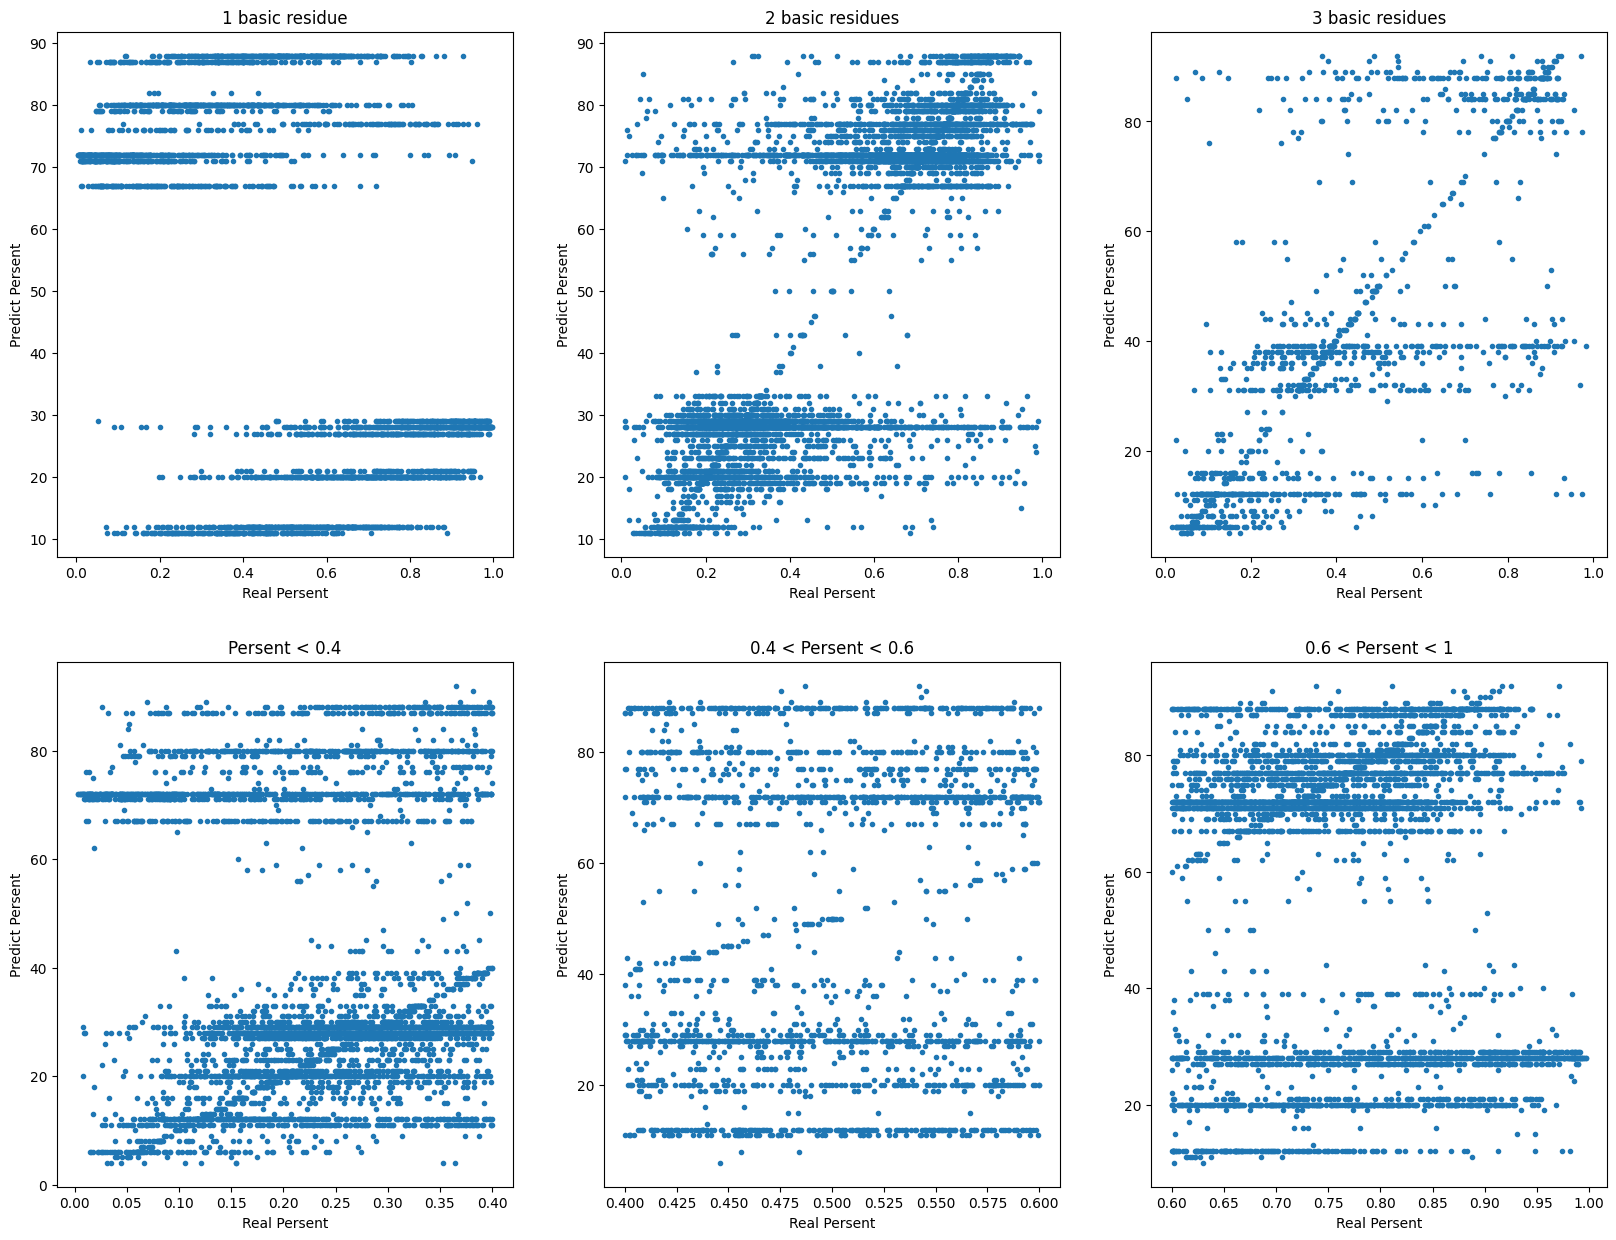

In [22]:
fig, ax = plt.subplots(2,3, figsize=(20,15))
ax[0][0].plot(persent_1, pred_1,'.')
ax[0][0].set_title('1 basic residue')
ax[0][0].set_xlabel('Real Persent')
ax[0][0].set_ylabel('Predict Persent')
ax[0][1].plot(persent_2, pred_2,'.')
ax[0][1].set_title('2 basic residues')
ax[0][1].set_xlabel('Real Persent')
ax[0][1].set_ylabel('Predict Persent')
ax[0][2].plot(persent_3, pred_3,'.')
ax[0][2].set_title('3 basic residues')
ax[0][2].set_xlabel('Real Persent')
ax[0][2].set_ylabel('Predict Persent')
ax[1][0].plot(littel_persent_real, pred_littel,'.')
ax[1][0].set_title('Persent < 0.4')
ax[1][0].set_xlabel('Real Persent')
ax[1][0].set_ylabel('Predict Persent')
ax[1][1].plot(mean_persent_real, pred_mean,'.')
ax[1][1].set_title('0.4 < Persent < 0.6')
ax[1][1].set_xlabel('Real Persent')
ax[1][1].set_ylabel('Predict Persent')
ax[1][2].plot(big_persent_real, pred_big,'.')
ax[1][2].set_title('0.6 < Persent < 1')
ax[1][2].set_xlabel('Real Persent')
ax[1][2].set_ylabel('Predict Persent')
plt.show()